# Enhancing Deep Fake Detection in Multimedia: A Fusion of CNN and RNN Approaches

## Training the model using a custom-designed CNN Architecture

A specialized CNN model is constructed with the purpose of detecting artificially generated media.

To obtain references for this specific task, please follow the provided link: https://www.kaggle.com/code/krooz0/deep-fake-detection-on-images-and-videos

## Importing the Libraries

In [1]:
import os
import cv2
import sklearn
import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

## About Dataset

The dataset is obtained from Kaggle, and you can access it by visiting the provided link: https://www.kaggle.com/datasets/dagnelies/deepfake-faces

The dataset comprises two components: a metadata CSV file and a "faces_224" folder. The metadata.csv file contains information about each image within the "faces_224" folder, specifically indicating whether an image is classified as "Real" or "Fake." The "videoname" column in the metadata file lists the names of the images corresponding to the ones in the "faces_224" folder. Additionally, the "label" column specifies the class to which each image belongs, either "Fake" or "Real."

In [2]:
def get_data():
    return pd.read_csv('/Path/metadata.csv')
meta = get_data()
meta.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [3]:
shape = meta.shape
print(f"Total Number of rows in the Metadata set: {shape[0]}")

len_FAKE = len(meta[meta.label == 'FAKE'])
len_REAL = len(meta[meta.label == 'REAL'])

print(f"The total number of 'REAL' samples in faces_224 folder: {len_REAL}")
print(f"The total number of 'FAKE' samples in faces_224 folder: {len_FAKE}")

Total Number of rows in the Metadata set: 95634
The total number of 'REAL' samples in faces_224 folder: 16293
The total number of 'FAKE' samples in faces_224 folder: 79341


In [4]:
real_labels = meta[meta["label"] == "REAL"]
fake_labels = meta[meta["label"] == "FAKE"]

#Creating a sample size of 8000 images in each Real and Fake classes, in total of 16000 images
sample_size = 8000

real_labels = real_labels.sample(sample_size)
fake_labels = fake_labels.sample(sample_size)

sample_metadata = pd.concat([real_labels, fake_labels])

Given the prevalence of more Fake images compared to Real images, we opt for undersampling to address the imbalanced dataset. In this approach, we create a balanced sample with a total size of 16000, evenly distributing 8000 images for each class.

In [5]:
Training_set, Testing_set = train_test_split(sample_metadata,
                                             test_size = 0.2,
                                             stratify = sample_metadata['label'])

print("Number of samples in Training Set:", len(Training_set))
print("Number of samples in Testing Set:", len(Testing_set))

Number of samples in Training Set: 12800
Number of samples in Testing Set: 3200


Partitioning the dataset into training and testing sets involves the creation of a "Training_set" and a "Testing_set". The "Testing_set" is composed of 3200 images, accounting for 20% of the entire 16000-image dataset, as specified by the test size of 0.2 during the splitting process.

## Combining the Dataset

This code is responsible for creating image datasets (X_train, X_test) along with their respective labels (y_train, y_test) using the provided training and testing datasets (Training_set, Testing_set). The procedure involves reading images, converting them into numpy arrays, and assigning labels based on the 'label' column extracted from the metadata.csv file. The label encoding strategy designates 0 for 'REAL' and 1 for 'FAKE'.

This crucial step is aimed at training the model with images and their corresponding labels (i.e., Real or Fake). The "load_dataset" method is employed for this purpose.

In [6]:
def load_dataset(set_name):
    images = []
    labels = []
    for index, row in set_name.iterrows():
        img_path = os.path.join('/Path/faces_224',
                                row['videoname'][:-4] + '.jpg')

        img = cv2.imread(img_path)
        images.append(img)
        labels.append(0 if row['label'] == 'REAL' else 1)
    return np.array(images), np.array(labels)

In [7]:
X_train, y_train = load_dataset(Training_set)
X_test, y_test = load_dataset(Testing_set)

## Building the CNN Architecture

This model processes input images with dimensions of 224x224 pixels.

In [8]:
input_shape = (224, 224, 3)

In [9]:
DFDI = tf.keras.models.Sequential()

##DFDI Stands for "Deep Fake Detection Image"

## Batch 1

Two convolutional layers are employed, each featuring 64 filters with a kernel size of 2. Additionally, a max-pooling layer with a kernel size of 2 is included.

In [10]:
DFDI.add(Conv2D(64, (2, 2), input_shape = input_shape, activation = 'relu',
                kernel_initializer = "he_normal", padding = "same"))

DFDI.add(Conv2D(64, (2, 2), input_shape = input_shape, activation = 'relu',
                kernel_initializer = "he_normal", padding = "same"))

DFDI.add(MaxPooling2D(2, 2))

## Batch 2

Two convolutional layers are employed, each featuring 128 filters with a kernel size of 3. Additionally, a max-pooling layer with a kernel size of 2 is included.

In [11]:
DFDI.add(Conv2D(128, (3, 3), input_shape = input_shape, activation = 'relu',
                kernel_initializer = "he_normal", padding = "same"))

DFDI.add(Conv2D(128, (3, 3), input_shape = input_shape, activation = 'relu',
                kernel_initializer = "he_normal", padding = "same"))

DFDI.add(MaxPooling2D(2, 2))

## Flattening Layer

In [12]:
DFDI.add(Flatten())

## ANN Architecture

The structure of the Artificial Neural Network includes layers with the following neuron counts: 512, 256, a dropout layer, 128, and 64, each utilizing the ReLU activation function. The final layer comprises 1 neuron with the "Sigmoid" activation function.

The dropout layer is used in neural networks as a regularization technique to prevent overfitting.

In [13]:
DFDI.add(Dense(512, activation = 'relu', kernel_initializer = "he_normal"))
DFDI.add(Dense(256, activation = 'relu', kernel_initializer = "he_normal"))

# Dropout layer with droupout rate set to 0.5
DFDI.add(Dropout(0.5))
DFDI.add(Dense(128, activation = 'relu', kernel_initializer = "he_normal"))
DFDI.add(Dense(64, activation = 'relu', kernel_initializer = "he_normal"))

DFDI.add(Dense(units = 1, activation = 'sigmoid'))

# Compiling the Neural Network
DFDI.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy'])

## Model Summary

In [14]:
DFDI.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      16448     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

## Training the Model

The model is trained using a dataset of size 16,000 for a total of 400 batches throughout 15 epochs, employing a batch size of 32.

In [15]:
batch_size = 32

history = DFDI.fit(X_train,
                   y_train,
                   epochs = 15,
                   steps_per_epoch = len(X_train) // batch_size,
                   validation_data = (X_test, y_test),
                   validation_steps=len(X_test) // batch_size,
                   )

Epoch 1/15
400/400 [==============================] - 114s 254ms/step - loss: 126.8326 - accuracy: 0.4952 - val_loss: 0.6933 - val_accuracy: 0.5013
Epoch 2/15
400/400 [==============================] - 102s 256ms/step - loss: 0.7169 - accuracy: 0.5004 - val_loss: 0.6915 - val_accuracy: 0.5006
Epoch 3/15
400/400 [==============================] - 108s 269ms/step - loss: 0.6929 - accuracy: 0.5032 - val_loss: 0.6918 - val_accuracy: 0.5022
Epoch 4/15
400/400 [==============================] - 104s 259ms/step - loss: 0.6928 - accuracy: 0.5038 - val_loss: 0.6920 - val_accuracy: 0.5022
Epoch 5/15
400/400 [==============================] - 104s 259ms/step - loss: 0.6913 - accuracy: 0.5041 - val_loss: 0.6913 - val_accuracy: 0.5000
Epoch 6/15
400/400 [==============================] - 108s 270ms/step - loss: 0.6925 - accuracy: 0.4973 - val_loss: 0.6962 - val_accuracy: 0.5022
Epoch 7/15
400/400 [==============================] - 104s 259ms/step - loss: 0.6915 - accuracy: 0.4991 - val_loss: 0.6911

## Evalutation of the Model

In [16]:
DFDI.evaluate(X_test, y_test)

100/100 [==============================] - 6s 56ms/step - loss: 0.6922 - accuracy: 0.5013


[0.6921943426132202, 0.5012500286102295]

## Plotting the Curves

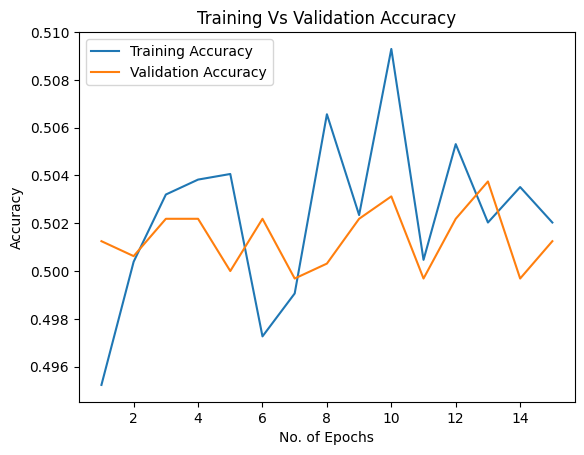

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs_range = range(1, len(history.epoch) + 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.legend()
plt.show()

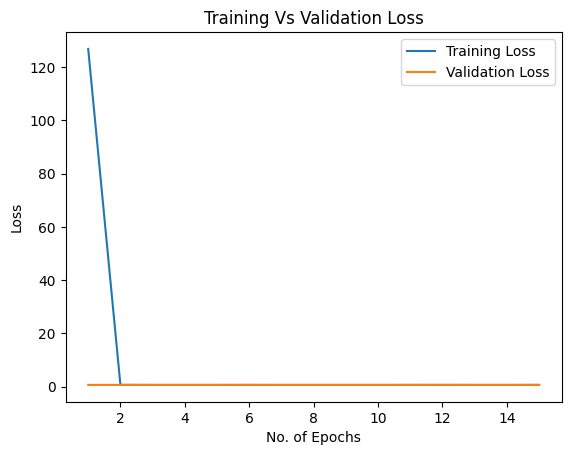

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Training Vs Validation Loss')
plt.legend()
plt.show()